## Volcano plot

In [1]:
library(ggplot2)
library(ggthemes)
library(ggrepel)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
source("../util.R")

In [3]:
table <- read.table(
    'hl60_delta_te_table.txt',header=T
)

In [4]:
table %>% 
    select(gene_name, Estimate_treatmentDRUG, qvalue_Pr...z.._treatmentDRUG) -> res 
# %>% column_to_rownames('gene_name') 

colnames(res) <- c('gene_name','lnFoldChange', 'qvalue')

In [46]:
lfc.cutoff = log(2)
qval.cutoff = 0.01
colors_values = c("grey80", "tan")
x_min = -4
x_max = 4
y_max = 10
title = expression(Delta*" TE")

top_hits = res %>% filter(
            abs(lnFoldChange) >= lfc.cutoff, 
            qvalue < qval.cutoff) %>% select('gene_name') %>% as.list %>% unlist %>% unname

target_genes = c(
    'SQLE','INTS5'
)

labels <- c(top_hits,target_genes)


vol <- res %>% ggplot(aes(x = lnFoldChange, y = -log10(qvalue))) + 
    geom_point(
        data = res %>% filter(
            abs(lnFoldChange) >= lfc.cutoff, 
            qvalue < qval.cutoff), 
        aes(x = lnFoldChange, y = -log10(qvalue)), 
        size = 3, alpha = 5/10, shape = 21, 
        color = "grey40", fill = colors_values[2]) + 

    geom_point(
        data = res %>% filter(
            (abs(lnFoldChange) < lfc.cutoff) | 
            (qvalue >= qval.cutoff)), 
        aes(x = lnFoldChange, y = -log10(qvalue)), 
        size = 1, alpha = 5/10, shape = 21, color = colors_values[1], 
        fill = colors_values[1]) + 
    
    geom_point(
        data = res %>% filter(gene_name %in% labels),
        aes(x = lnFoldChange, y = -log10(qvalue)), 
        shape = 21, size = 3, color = "grey40", fill = "red3") + 

    geom_label_repel(
        data = res %>% filter(gene_name %in% labels), 
        aes(label = gene_name), box.padding = 1, max.overlaps = Inf) + 
    
    xlim(c(x_min, x_max)) + 
    ylim(c(0, y_max)) + 
    geom_hline(yintercept = -log10(qval.cutoff), linetype = "dashed", alpha = 5/10) + 
    geom_text(aes(
        x_min*0.8,-log10(qval.cutoff),
        label = paste("-~log[10]~(",qval.cutoff,')',sep=''), 
        vjust = x_min*0.05
    ),parse = TRUE) +
    
    theme(
        legend.position = "none"
    ) + 
    ggtitle(title) + theme_Publication()


Warning message:
“Removed 1 rows containing missing values (geom_point).”


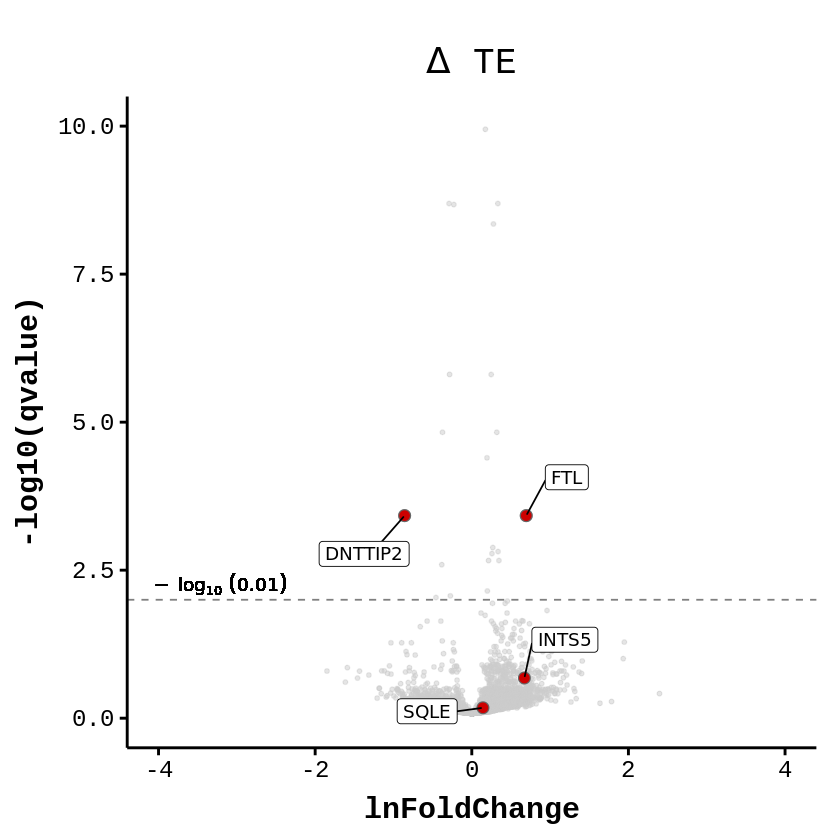

In [47]:
vol

In [48]:
ggsave(
    'plots/volcano_delta_te.pdf', plot = vol, 
    device = 'pdf', width = 5, height=5.5, dpi = 300
)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


In [17]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.7     purrr_0.3.4    
 [5] readr_2.0.2     tidyr_1.1.4     tibble_3.1.6    tidyverse_1.3.1
 [9] ggrepel_0.9.1   ggthemes_4.2.4  ggplot2_3.3.5  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-6     tidyselect_1.1.1 repr_1.1.3      

In [18]:
date()

[1] "Thu Jan  6 04:36:41 2022"

## Pathway enrichment 

In [1]:
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time 
from glob import glob
from matplotlib.pyplot import subplots
from itertools import chain
from functools import reduce
from venn import venn

# sys.path.append('/rumi/shams/abe/Projects/ipage-down/')
sys.path.append('/data_gilbert/home/aarab/Projects/ipage-down/')

import ipage_down as ipd

### c5

In [135]:
df = ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(pvmat) for pvmat in [ 
            'hl60_delta_te/msigdb_v7.4_c5.all/pvmatrix.L.txt',
        ]
    ])
)


cols = df.columns

df = pd.concat([df] + [
    ipd.read_pvmatrix(pvmat).set_axis(cols, axis=1, inplace=False) 
    for pvmat in [ 
        # c5
        'hl60_delta_te/msigdb_v7.4_c5.go.mf/pvmatrix.L.txt',
        'hl60_delta_te/msigdb_v7.4_c5.go.mf/pvmatrix.R.txt',
        'hl60_delta_te/msigdb_v7.4_c5.all/pvmatrix.R.txt',
        'hl60_delta_te/msigdb_v7.4_c5.go/pvmatrix.L.txt',
#         'hl60_delta_te/msigdb_v7.4_c5.go.bp/pvmatrix.L.txt',
        'hl60_delta_te/msigdb_v7.4_c5.go.mf/pvmatrix.L.txt',
        'hl60_delta_te/msigdb_v7.4_c5.go.mf/pvmatrix.R.txt', 
        # c2
        'hl60_delta_te/msigdb_v7.4_c2.all/pvmatrix.L.txt',
        'hl60_delta_te/msigdb_v7.4_c2.all/pvmatrix.R.txt',
        'hl60_delta_te/msigdb_v7.4_c2.cgp/pvmatrix.R.txt',
        'hl60_delta_te/msigdb_v7.4_c2.cp.pid/pvmatrix.R.txt',
        'hl60_delta_te/msigdb_v7.4_c2.cp/pvmatrix.L.txt',
        'hl60_delta_te/msigdb_v7.4_c2.cp.reactome/pvmatrix.L.txt'
    ]]
)

df = df.groupby(df.index).first()
ipd.style_clean_pvmatrix(df.iloc[:,[0,10]])

,[-0.36 -0.28],[0.46 0.54]
BILD_SRC_ONCOGENIC_SIGNATURE,-1.453000,2.483000
HP_HEREDITARY_NONPOLYPOSIS_COLORECTAL_CARCINOMA,-0.663000,2.705000
GOMF_RACEMASE_AND_EPIMERASE_ACTIVITY_ACTING_ON_CARBOHYDRATES_AND_DERIVATIVES,-0.207000,3.514000
GOMF_KINETOCHORE_BINDING,-0.207000,2.195000
PID_TRAIL_PATHWAY,0.995000,2.243000
HP_ABNORMAL_ANTERIOR_CHAMBER_MORPHOLOGY,2.041000,0.642000
GOMF_MANGANESE_ION_BINDING,2.581000,1.084000
GOBP_MITOCHONDRIAL_RESPIRATORY_CHAIN_COMPLEX_ASSEMBLY,2.973000,-0.772000
REACTOME_SYNTHESIS_OF_DIPHTHAMIDE_EEF2,3.059000,-0.249000
HP_KETONURIA,3.267000,-0.538000


In [161]:
df.index = [f'{x} {x}' for x in df.index]

In [162]:
df.round(decimals=3).to_csv("hl60_delta_te_pvmatrix.txt",sep = '\t')

In [165]:
!bash ../ipage_draw_matrix.sh hl60_delta_te.txt hl60_delta_te_pvmatrix.txt

Reading matrix ... Done.
Cluster rows .. best merge is 2, 3, 0.0291787397836764
best merge is 2, 11, 0.0610110598508854
best merge is 2, 9, 0.153290984481121
best merge is 4, 6, 0.16525530851963
best merge is 5, 7, 0.226917270733825
best merge is 2, 5, 0.319597914831907
best merge is 1, 2, 0.397812377435333
best merge is 0, 4, 0.400169982748174
order classes
7 - 0.404546845499467
2 - 0.495765925558889
1 2 3 11 9 5 7
0
4 6
8
10
Done.Start drawing
0.5	-0.5
BILD_SRC_ONCOGENIC_SIGNATURE
GOMF_KINETOCHORE_BINDING
GOMF_RACEMASE_AND_EPIMERASE_ACTIVITY_ACTING_ON_CARBOHYDRATES_AND_DERIVATIVES
PID_TRAIL_PATHWAY
HP_HEREDITARY_NONPOLYPOSIS_COLORECTAL_CARCINOMA
GOBP_MITOCHONDRIAL_RESPIRATORY_CHAIN_COMPLEX_ASSEMBLY
GOBP_PEPTIDYL_HISTIDINE_MODIFICATION
GOMF_CCR_CHEMOKINE_RECEPTOR_BINDING
REACTOME_SYNTHESIS_OF_DIPHTHAMIDE_EEF2
HP_KETONURIA
GOMF_MANGANESE_ION_BINDING
HP_ABNORMAL_ANTERIOR_CHAMBER_MORPHOLOGY
Outputing EPS file hl60_delta_te.txt_PAGE/hl60_delta_te.txt.summary.eps
Convert to PDF hl60_delta_

In [169]:
!rm hl60_delta_te_pvmatrix.txt
!mv hl60_delta_te.pdf plots/ipage_heatmap.pdf

In [ ]:
!date